## DATA604 - Midterm 2
### Fashion MNIST Dataset

**The dataset is taken from Zalando Research’s github repository.**

**Link: https://github.com/zalandoresearch**

In [2]:
# import required libraries
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import random

In [3]:
# function to unzip data files.
# the function is taken from Zalando Research’s github repository.
import os
import gzip

def load_mnist(path, kind='train'):

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
# load train data
path = 'data/'
X_train, y_train = load_mnist(path, kind='train')
X_train.shape

(60000, 784)

In [5]:
# load test data
X_test, y_test = load_mnist(path, kind='t10k')
X_test.shape

(10000, 784)

In [6]:
# Standardizing the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Q1

In [8]:
# apply PCA
pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train)

# Principal component matrix
# Shape: 784x784
P = pca.components_.T 
P.shape

(784, 784)

## Q1. b

In [10]:
# pick 2 samples per class
p_idx = []
for label in range(10):
    idx = np.where(y_train.flatten() == label)[0]
    random_idx = random.sample(list(idx), 2)
    p_idx.extend(random_idx)

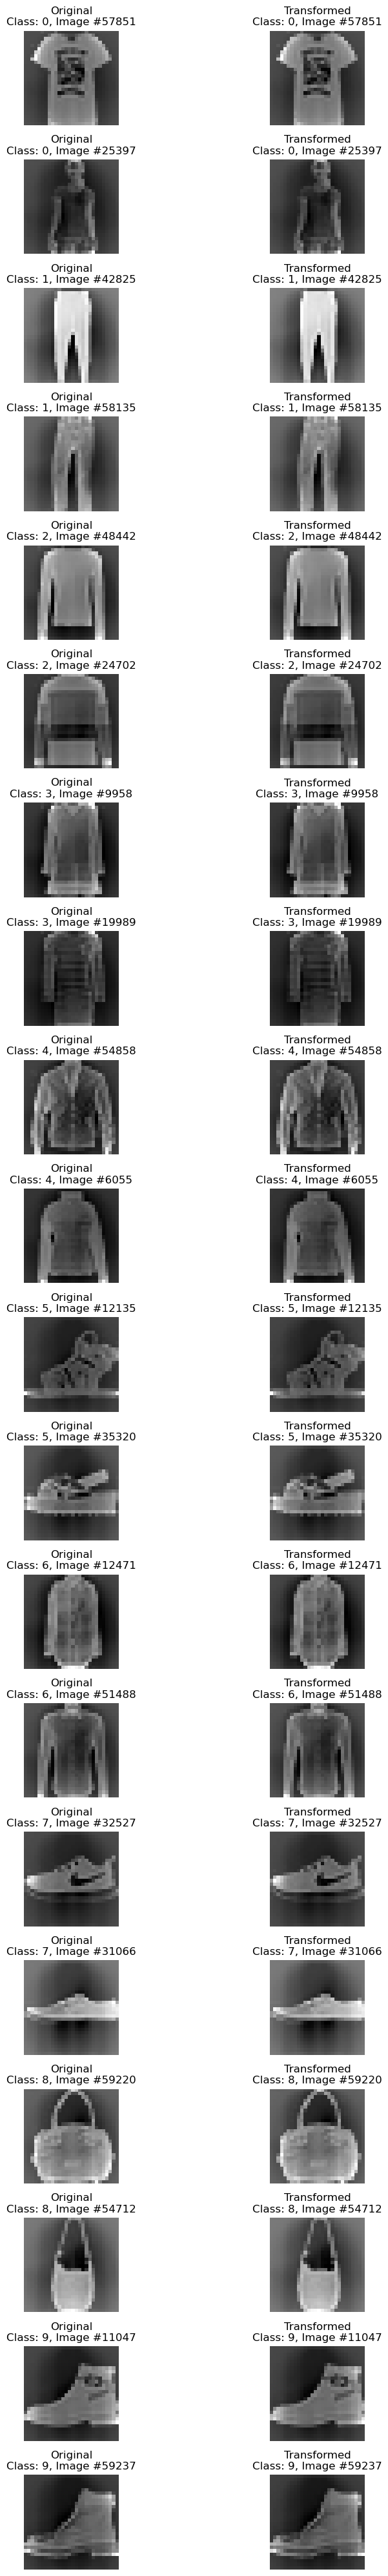

In [11]:
# Plotting the images of each class and using principal components
fig, axes = plt.subplots(20, 2, figsize=(10, 40))

for i, img_idx in enumerate(p_idx):
    x_orig = X_train[img_idx]

    # Display Original Image
    axes[i, 0].imshow(x_orig.reshape(28,28), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Original\nClass: {y_train[img_idx]}, Image #{img_idx}')
    
    # Transformed Image T(x) = Px
    x_transformed = P.T @ x_orig
    # Reconstruct back to pixel space
    x_reconstructed = P @ x_transformed
    
    # Display Reconstructed Image
    axes[i, 1].imshow(x_reconstructed.reshape(28,28), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Transformed\nClass: {y_train[img_idx]}, Image #{img_idx}')

plt.tight_layout()
plt.show()

## Q1. c.

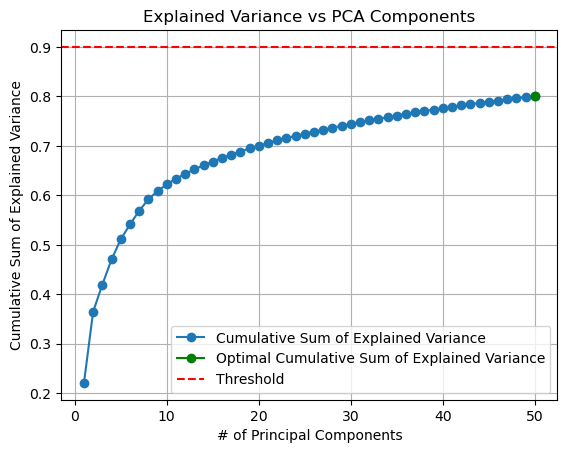

In [13]:
# pick optimal number of principal components between 1 and 50
# set threshold of features captured at 90% 
threshold = 0.90
cumulative_var = []
max_var = 0
n_optimal = 1
for i in range(1,51):
    c_var = sum(pca.explained_variance_ratio_[:i])
    cumulative_var.append(c_var)
    if c_var>max_var and max_var<=threshold:
        cutoff_var = c_var
        n_optimal = i
    
plt.plot(range(1,51),cumulative_var, marker='o', label='Cumulative Sum of Explained Variance')
plt.plot(n_optimal,cutoff_var, marker='o', color = 'g', label='Optimal Cumulative Sum of Explained Variance')
plt.axhline(y = threshold, linestyle ='--', color = 'r', label='Threshold')
plt.xlabel("# of Principal Components")
plt.ylabel("Cumulative Sum of Explained Variance")
plt.title("Explained Variance vs PCA Components")
plt.legend()
plt.grid(True)
plt.show()

The curve starts to flatten after n_components = 10. This indicates that additional components do not contribute much.
Even at 50 principal components, the cumulative explained variance is lesser than 90%.
Therefore, I choose 50 principal components as the optimal number for dimensionality reduction.
This choice reduces dimensionality by more than 93% (from 784 to 50).
It is suitable to keep more than 90% of the data, but we are in a constraint to choose the n_components in range(1,50).
Choosing more components would increase computational cost without substantial gains in explained variance.

In [15]:
# print cumulative sum at N_optimal
print(f"Cumulative Sum of Explained Ratio = {cutoff_var:.4f} when n_components = {n_optimal}")

Cumulative Sum of Explained Ratio = 0.8007 when n_components = 50


# Q2

In [17]:
# using PCA with optimal components
pca = PCA(n_components=n_optimal)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [18]:
# Run kNN and find best k value
K = [5, 10, 15, 20]
global_acc = []

# train KNN for each value of K
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_test_pca)
    acc =accuracy_score(y_test, y_pred)
    global_acc.append(acc)
    
    print(f"\nResults for k={k}")
    print("Overall Accuracy:", acc)
    print("Success Rates per Class:")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))


Results for k=5
Overall Accuracy: 0.8506
Success Rates per Class:
              precision    recall  f1-score   support

           0     0.7710    0.8180    0.7938      1000
           1     0.9857    0.9620    0.9737      1000
           2     0.7531    0.7810    0.7668      1000
           3     0.8788    0.8630    0.8708      1000
           4     0.7425    0.7700    0.7560      1000
           5     0.9664    0.8920    0.9277      1000
           6     0.6336    0.5810    0.6062      1000
           7     0.8924    0.9370    0.9141      1000
           8     0.9724    0.9500    0.9611      1000
           9     0.9154    0.9520    0.9333      1000

    accuracy                         0.8506     10000
   macro avg     0.8511    0.8506    0.8504     10000
weighted avg     0.8511    0.8506    0.8504     10000


Results for k=10
Overall Accuracy: 0.8546
Success Rates per Class:
              precision    recall  f1-score   support

           0     0.7812    0.8460    0.8123      10

In [19]:
# find highest accuracy
best_idx = np.argmax(global_acc)
best_k = K[best_idx]
best_acc = global_acc[best_idx]
print(f"Highest Accuracy is {best_acc:.4f} at k={best_k}")

Highest Accuracy is 0.8546 at k=10


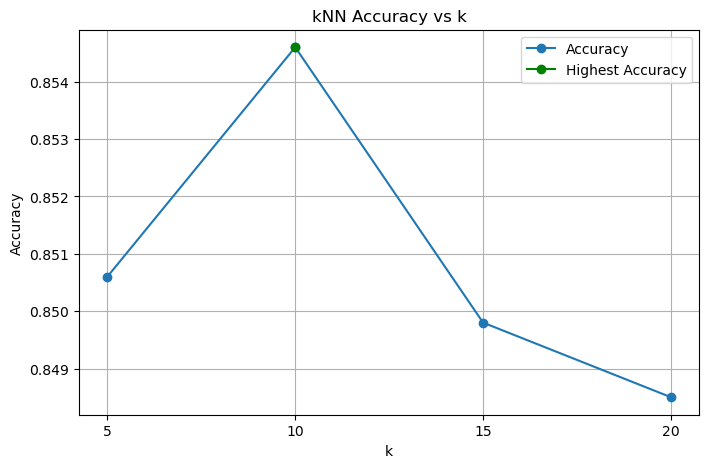

In [20]:
# plot of accuracy for different values ok k
plt.figure(figsize=(8,5))
plt.plot(K,global_acc, marker='o', label='Accuracy')
plt.plot(best_k, best_acc, marker='o', color='g',label='Highest Accuracy')
plt.xlabel("k")
plt.xticks(K)
plt.ylabel("Accuracy")
plt.title("kNN Accuracy vs k")
plt.legend()
plt.grid(True)
plt.show()

# Q3

In [22]:
# Run Linear SVM on the pca transformed dataset
from sklearn.svm import LinearSVC

svm = LinearSVC(dual=False, max_iter=10000)
svm.fit(X_train_pca, y_train)
y_pred = svm.predict(X_test_pca)
linear_svm_acc = accuracy_score(y_test, y_pred)

print("\n Results for Linear SVM:")
print("Overall Accuracy: ", linear_svm_acc)
print("Success Rates per Class:")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))


 Results for Linear SVM:
Overall Accuracy:  0.8139
Success Rates per Class:
              precision    recall  f1-score   support

           0     0.7587    0.8080    0.7826      1000
           1     0.9655    0.9520    0.9587      1000
           2     0.7119    0.6770    0.6940      1000
           3     0.7840    0.8600    0.8202      1000
           4     0.6711    0.7650    0.7150      1000
           5     0.9059    0.8950    0.9004      1000
           6     0.5805    0.4110    0.4813      1000
           7     0.8886    0.9010    0.8947      1000
           8     0.9106    0.9370    0.9236      1000
           9     0.9129    0.9330    0.9228      1000

    accuracy                         0.8139     10000
   macro avg     0.8090    0.8139    0.8093     10000
weighted avg     0.8090    0.8139    0.8093     10000



In [23]:
# Run SVM with RBF kernel on the pca transformed dataset

from sklearn.svm import SVC

# Train SVM using One-vs-Rest
svm = SVC(kernel='rbf', decision_function_shape='ovr')
svm.fit(X_train_pca, y_train)
y_pred = svm.predict(X_test_pca)
rbf_svm_acc = accuracy_score(y_test, y_pred)

print("\n Results for SVM using RBF kernel:")
print("Overall Accuracy: ", rbf_svm_acc)
print("Success Rates per Class:")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))


 Results for SVM using RBF kernel:
Overall Accuracy:  0.8669
Success Rates per Class:
              precision    recall  f1-score   support

           0     0.8144    0.8380    0.8260      1000
           1     0.9917    0.9560    0.9735      1000
           2     0.7838    0.7720    0.7778      1000
           3     0.8523    0.8890    0.8703      1000
           4     0.7816    0.7980    0.7897      1000
           5     0.9616    0.9260    0.9435      1000
           6     0.6788    0.6360    0.6567      1000
           7     0.9082    0.9400    0.9238      1000
           8     0.9605    0.9730    0.9667      1000
           9     0.9317    0.9410    0.9363      1000

    accuracy                         0.8669     10000
   macro avg     0.8665    0.8669    0.8664     10000
weighted avg     0.8665    0.8669    0.8664     10000



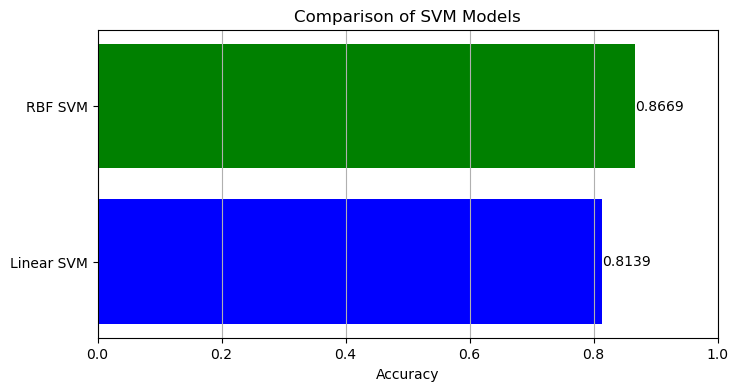

In [25]:
# Plot the accuracy the SVM Models
# Data
models = ['Linear SVM', 'RBF SVM']
svm_accuracies = [linear_svm_acc, rbf_svm_acc]

# Determine colors: green for highest, blue for others
colors = ['blue', 'blue']
max_idx = np.argmax(svm_accuracies)
colors[max_idx] = 'green'

# Plot
plt.figure(figsize=(8,4))
plt.barh(models, svm_accuracies, color=colors)
plt.xlabel('Accuracy')
plt.title('Comparison of SVM Models')

# Show the accuracy value next to bars
for index, value in enumerate(svm_accuracies):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.xlim(0, 1)
plt.grid(axis='x')
plt.show()